In [2]:
import json
from pathlib import Path
import pandas as pd
import spacy
import re
import collections
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [3]:
nlp = spacy.load("en_core_web_lg")

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [69]:
def chart(fin,ctype,label):
    if ctype == 'pie':
        cnt=6
    else:
        cnt = 20
    counter=collections.Counter(fin)
    counts = counter.most_common(cnt)
    keys   = [i[0] for i in counts]
    print(len(keys))
    values = [i[1] for i in counts]
    d = dict(zip(keys,values))
    if ctype=='pie':
        plt.figure(figsize=(5,5))
        pyplot.pie([float(v) for v in d.values()], labels=[k for k in d.keys()],autopct=None)
        plt.show()
    else:
#         plt.legend([label])
        plt.figure(figsize=(10,10))
        plt.xlabel(label)
        plt.ylabel('Frequency')
        plt.title(label)
        plt.bar(range(len(d)), list(d.values()), align='center')
        plt.xticks(range(len(d)), list(d.keys()))
        for index, value in enumerate(values):
            plt.text(index,value, str(value),rotation='vertical')
#         plt.show()

In [7]:
def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad(r'C:\Users\guruvayura.ravic\Downloads\train-v2.0.json')

In [18]:
len(train_questions)

86821

In [8]:
answers = [i['text'] for i in train_answers]

In [9]:
squad_dataset = pd.DataFrame({'question':train_questions,'context':train_contexts,'answer':answers})

In [10]:
squad_dataset['question_word'] = [i.split(' ')[0] for i in squad_dataset.question] 

In [11]:
# squad_dataset["context"] = squad_dataset['context'].str.replace('[^\w\s]','')

In [12]:
# squad_dataset["answer"] = squad_dataset['answer'].str.replace('[^\w\s,]','')

In [13]:
squad_dataset = squad_dataset.apply(lambda x: x.astype(str).str.lower())

10


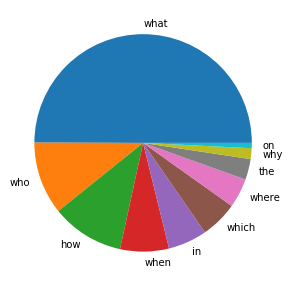

In [23]:
fin = list(squad_dataset.question_word)
chart(fin,'pie','Question_Word_Type')

4


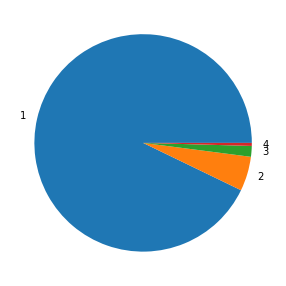

In [49]:
squad_dataset['no_of_answers'] = [len(i.split(',')) for i in squad_dataset.answer]
fin = list(squad_dataset.no_of_answers)
chart(fin,'pie','number of answers for a question')

4


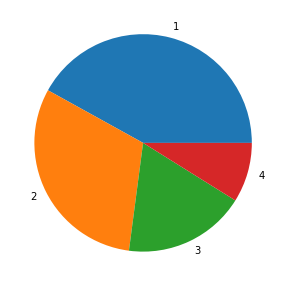

In [50]:
squad_dataset['answer_length'] = [len(i.split(' ')) for i in squad_dataset.answer]
fin = list(squad_dataset.answer_length)
chart(fin,'pie','length of each answer for a question')

In [51]:
who_qns = squad_dataset[squad_dataset['question_word']=='who']

In [52]:
who_qns = who_qns.sample(frac=1)

In [53]:
who_qns = who_qns[(who_qns['no_of_answers']==1) & (who_qns['answer_length']==2)]

In [54]:
len(who_qns)

3542

In [45]:
spacy.explain('PROPN')

'proper noun'

In [71]:
fin = []
for i,j in who_qns.iterrows():
#     print('Question:',j[0],'\n')
#     print('Context:',j[1])
#     print('Answer:',j[2],'\n')
    
    ans_wrd = j[2].split(" ")[0]
    ans_wrd_len = len(j[2].split(" "))
    
    doc = nlp(j[1])
    flag=False
    for ent in doc:
        
        if flag==True:
            s=s+" "+ent.pos_
            fin.append(s)
            flag=False
            continue
            
        if ans_wrd == ent.text:
            if ans_wrd_len>1:
                flag=True
                s=ent.pos_
            else:
                s = ent.pos_
                fin.append(s)

6


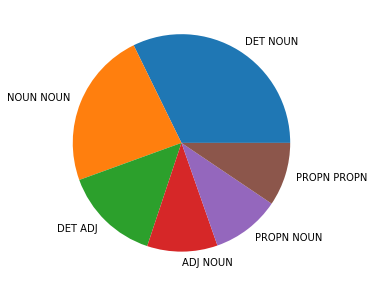

In [72]:
chart(fin,'pie',None)

In [57]:
def extract(nlp, text, patterns, re_patterns):
    """Extracts the pieces in text maching the POS pattern in patterns

    args:
        nlp : Loaded Spicy model object
        text: The input text
        patterns: The list of patters to be searched
        re_patterns: The patterns converted into regex

    returns: A list of tuples of form (t,p) where 
    t is the part of text matching the pattern p in patterns
    """
    doc = nlp(text)   
    matches = list()
    text_pos = " ".join([token.text+"_!"+token.pos_ for token in doc])
    for i, pattern in enumerate(re_patterns):
        for result in re.findall(pattern, text_pos):
#             matches.append(list(set([" ".join(result), patterns[i]])))
              matches.append(" ".join(result))  
    return ','.join(set(matches))

In [58]:
# Patters we are intrested in 
patterns = ["DET NOUN","NOUN NOUN","DET ADJ","ADJ NOUN","PROPN NOUN","PROPN PROPN","NOUN PROPN"]

# Convert each pattern into regular expression
re_patterns = [" ".join(["(\w+)_!"+pos for pos in p.split()]) for p in patterns]

In [59]:
result=[]
for i,j in who_qns.iterrows():
    result.append(extract(nlp,j[1],patterns,re_patterns))

In [60]:
who_qns['pos_matched_tokens'] = result

In [61]:
who_qns['no_of_matched_keywords'] = [len(i.split(',')) for i in who_qns['pos_matched_tokens']]

In [62]:
print('Average no of keywords obtained:',who_qns['no_of_matched_keywords'].mean())

Average no of keywords obtained: 26.339638622247318


20


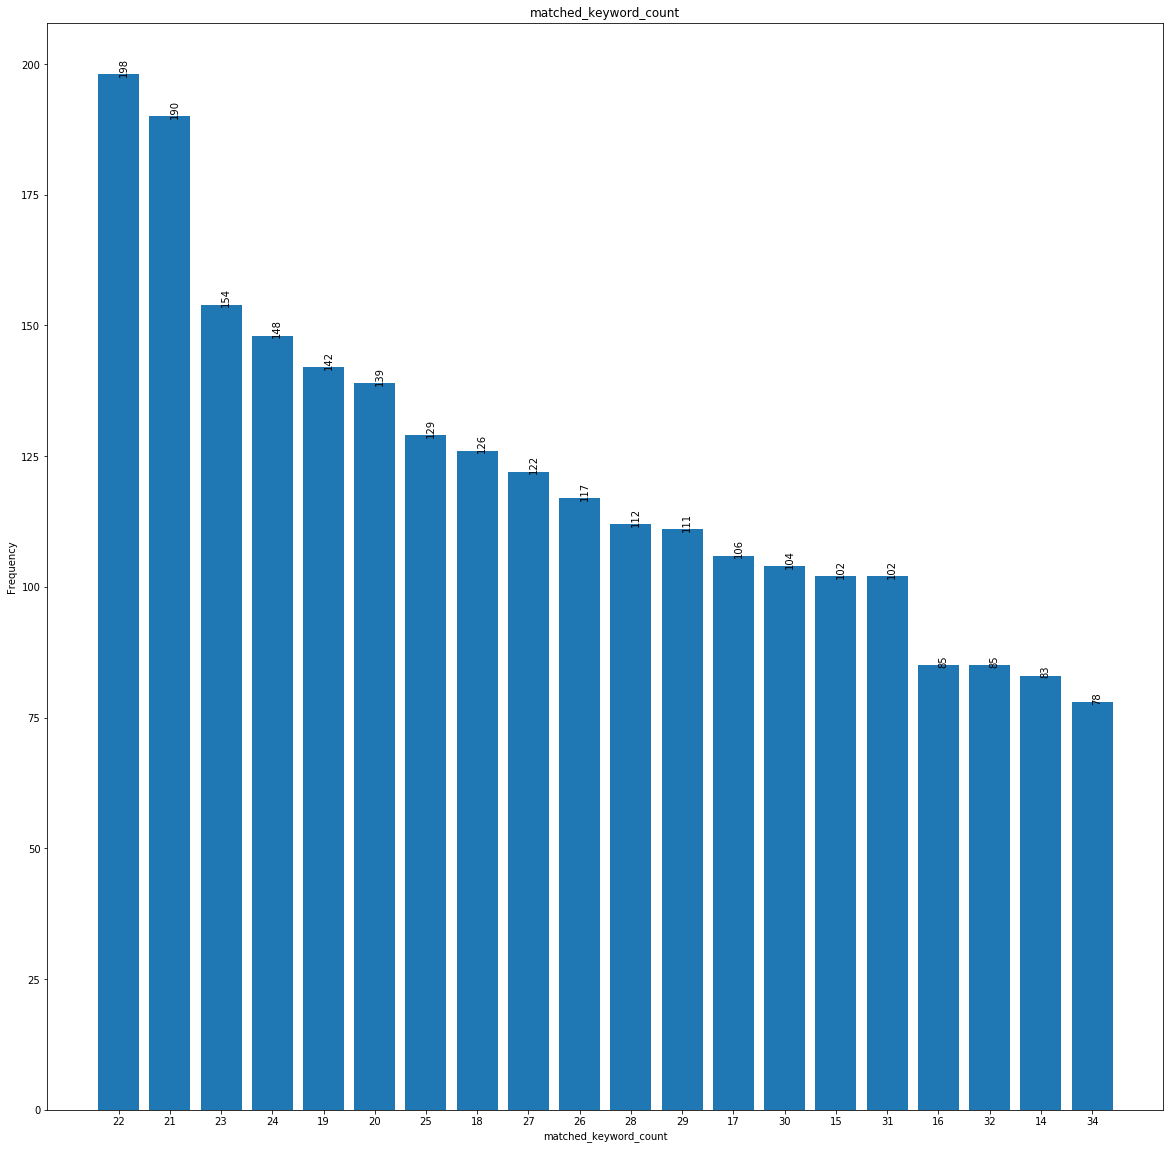

In [63]:
fin = list(who_qns['no_of_matched_keywords'])
chart(fin,'bar','matched_keyword_count')

In [64]:
who_qns['isanswerPresent'] = who_qns.apply(lambda x: x.answer in x.pos_matched_tokens, axis=1)

2


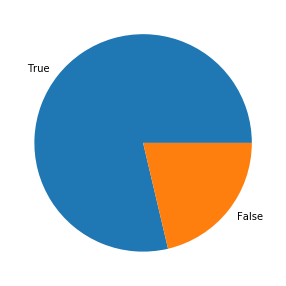

In [73]:
fin = list(who_qns['isanswerPresent'])
chart(fin,'pie','isanswerPresent_in_posmatchedkeywords')
#2787 , 755

In [42]:
who_qns = who_qns[['question','context','answer','pos_matched_tokens','no_of_matched_keywords','isanswerPresent']]

In [43]:
who_qns.to_csv('Who_analysis.csv')

In [24]:
for i,j in who_qns.iloc[:5].iterrows():
    print('Question:',j[0],'\n')
#     print('Context:',j[1])
    print('Answer:',j[2],'\n')
    ans_wrd = j[2].split(" ")[0]
    doc = nlp(j[1])
    for ent in doc.ents:
#         if ent.text == ans_wrd:
                print(ent.text,ent.label_)

Question: who accused the arab government of practicing acts of racism? 

Answer: george ayittey 

american NORP
Question: who wrote "childe harold's pilgrimage: canto i"? 

Answer: lord byron 

today DATE
Question: who discussed emotions in the context of expressive body actions and cultural labels? 

Answer: peggy thoits 

one CARDINAL
william james PERSON
Question: who did hoyte van hoytema replace as cinematographer? 

Answer: roger deakins 

2013 DATE
24 CARDINAL
first ORDINAL
two CARDINAL
1987 DATE
1989 DATE
john logan PERSON
sixth ORDINAL
4 CARDINAL
mendes PERSON
craig dennis PERSON
july 2015 DATE
over one thousand CARDINAL
craig PERSON
Question: who authored whitehead's biography that is considered to be the most reliable description of whitehead's life? 

Answer: victor lowe 

two CARDINAL
first ORDINAL
